In [2]:
%load_ext autoreload
%autoreload

from pyDOE import *
from pandas import read_csv,DataFrame
import numpy as np
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
from lib_for_paper import *
from pandas.io import wb


data_path="data/"
figures_path="figures_paper_python_march3/"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

co2_by_sector=read_csv(data_path+"enerdata_emissions_world.csv")
elec_comit=read_csv(data_path+"Future_Power_Sector_Emissions_Committed_ton_CO2.csv")
un_pop=read_csv(data_path+"Total_population_both_sexes_thousands.csv")

myyears=range(2013,2051)

%matplotlib inline

In [3]:
GDP_PPP_const_dol_2013 = 9.88E+13

In [4]:
global_emissions_2013_TCO2=10**9*co2_by_sector['2013'].sum()
co2_tertiary=10**9*co2_by_sector.loc[2,'2013']
co2_industry=10**9*co2_by_sector.loc[1,'2013']
co2_ener=10**9*co2_by_sector.loc[0,'2013']
co2_transport=10**9*co2_by_sector.loc[3,'2013']

#pop 2013
pop_ref=1000*(un_pop.ix[un_pop['year']==2013,'population'].values[0])

# per capita GDP 2013
gdp_pc_ref=GDP_PPP_const_dol_2013/pop_ref

# carbon intensity 2013 (tonCO2/dol)
carb_int_ref=global_emissions_2013_TCO2/GDP_PPP_const_dol_2013

ranges=read_csv(data_path+"scenarios_ranges.csv")
ranges1=ranges.drop(ranges.index[ranges['variable']=='budget'])
ranges2=ranges1.drop(ranges1.index[ranges1['variable']=='eleclife'])
scenarios=create_scenarios(ranges2,500)

In [5]:
ranges2

,variable,min,max
1,induslife,10.0000,50.0000
2,tertlife,20.0000,100.0000
3,transplife,5.0000,30.0000
4,GDPgrate,0.0000,0.0400
5,poprate,0.0047,0.0114


In [6]:
global_emissions_2013_TCO2/1000000000

30.570000000000004

In [7]:
hist_file=read_csv(data_path+"raw_data_world_2013.csv")
scenario_file=read_csv(data_path+"scenarios.csv")

In [8]:
scenario_file.head()

,years,SRES A1,RCP 45,RCP 26,SRES A1G,SRES A1T,SRES A2,SRES B1,SRES B2,RCP 6,RCP 85
0,1990,5.99,NaN,NaN,5.99,5.99,5.99,5.99,5.99,NaN,NaN
1,2000,6.90,6.735,6.735,6.90,6.90,6.90,6.90,6.90,6.735,6.735
2,2010,9.68,8.607,8.821,8.65,8.33,8.46,8.50,7.99,8.512,8.926
3,2020,12.12,9.872,9.288,11.19,10.00,11.01,10.00,9.02,8.950,11.538
4,2030,14.01,10.953,7.157,14.61,12.26,13.53,11.20,10.15,9.995,13.839


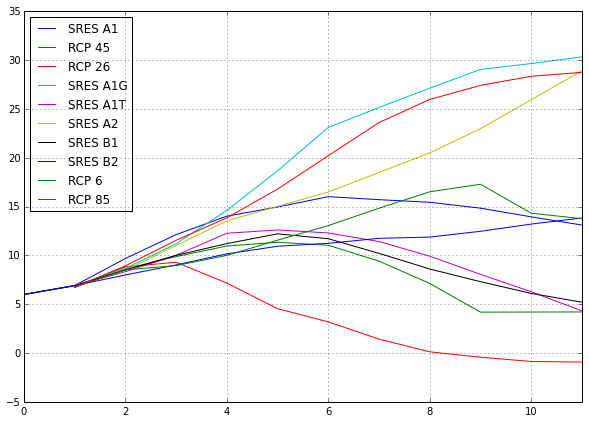

In [9]:
scenario_file.iloc[:,1::].plot(figsize=[10,7])

In [10]:
hist_emi=10**(-6)*hist_file["EN_ATM_CO2E_KT"]
hist_years=hist_file["Year"]

select50 = scenario_file['years']<=2050

rcp26 = 44/12*scenario_file.ix[select50,'RCP 26']
rcp45 = 44/12*scenario_file.ix[select50,'RCP 45']
rcp_years = scenario_file.ix[select50,'years']

Here I correct emissions data for the graph only, to make sure global emissions are 36GtCO2 in 2013

In [11]:
hist_emi[len(hist_emi)-1]=36
hist_emi.ix[hist_years==2011]=(hist_emi.ix[hist_years==2012].values[0]+hist_emi.ix[hist_years==2010].values[0])/2

In [12]:
carb_int_correct = carb_int_ref*36*10**(9)/global_emissions_2013_TCO2

In [13]:
from scipy.interpolate import interp1d

rcp26full=interp1d(scenario_file["years"], scenario_file["RCP 26"])
rcp45full=interp1d(scenario_file["years"], scenario_file["RCP 45"])

In [14]:
for col in scenario_file.columns:
    fulltraj=interp1d(scenario_file["years"], scenario_file[col])
    budget = sum(fulltraj(range(2001,2101)))
    print(col,budget)         


years 205050.0
SRES A1 1369.8
RCP 45 820.374
RCP 26 357.377
SRES A1G 2069.31
SRES A1T 965.955
SRES A2 1713.955
SRES B1 917.65
SRES B2 1092.96
RCP 6 1255.739
RCP 85 1954.3375


In [15]:
sum(rcp26full(range(2051,2100)))*44/12

45.714166666666678

In [16]:
sum(rcp45full(range(2051,2100)))*44/12

1164.1410000000003

In [17]:
traj = rcp26full(range(2013,2100))
print(sum(traj[traj<0]))
print(sum(traj<0))

-16.7648
27


In [18]:
44/12*sum(traj[traj<0])/sum(traj<0)

-2.2767012345679003

In [17]:
sum(traj[traj<0])/50

-0.33529599999999987

In [18]:
sum(rcp26full(myyears))*44/12

913.86313333333362

In [19]:
sum(rcp45full(myyears))*44/12

1479.2745000000002

In [20]:
for neg in [0,-1,-3,-5]:
    totnegemissions = neg*25
    by2050 = sum(rcp26full(range(2013,2051)))-(totnegemissions+16.7648)*(2050-2013)/(2075-2013)
    print(by2050*44/12)

877.178866667
931.883167742
1041.29176989
1150.70037204


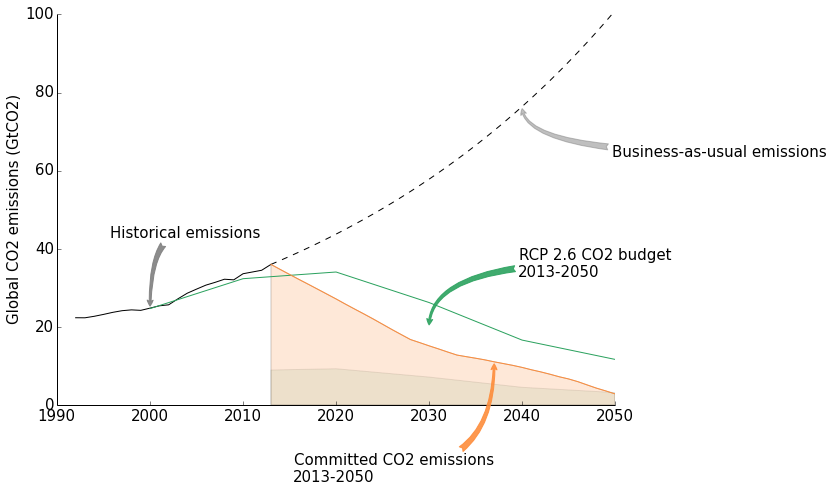

In [40]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

comitted = 10**(-9)*36*10**(9)/global_emissions_2013_TCO2*calc_all_comit(0,0,40,myyears,elec_comit,co2_industry,co2_tertiary,co2_transport,
                                         20,50,15,2013,co2_ener,carb_int_ref,gdp_pc_ref,0.0081,pop_ref)

plt.plot(hist_years,hist_emi,"black")
plt.plot(rcp_years,rcp26,color="#2ca25f")
plt.plot(myyears,10**(-9)*calc_bau_emissions(0.02,0,carb_int_correct,myyears,gdp_pc_ref,0.0081,pop_ref),color="black",linestyle='--')
plt.plot(myyears,comitted,color='#fd8d3c')
ax.set_ylim([0,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylabel("Global CO2 emissions (GtCO2)")

ax.fill_between(myyears,0,rcp26full(myyears) ,facecolor="#2ca25f",alpha=0.1, interpolate=True)
ax.fill_between(myyears,0,comitted ,facecolor="#fd8d3c",alpha=0.2, interpolate=True)

plt.annotate("Committed CO2 emissions\n2013-2050", xy=(2037,comitted[list(myyears).index(2037)]),  xycoords='data',
                            xytext=(-200,-120), textcoords='offset points',
                            arrowprops=dict(arrowstyle="fancy",
                                            fc="#fd8d3c", ec="#fd8d3c",
                                            patchB=None,alpha=0.9,
                                            connectionstyle="angle3,angleA=0,angleB=90"),
                                )

plt.annotate("RCP 2.6 CO2 budget\n2013-2050", xy=(2030,20),  xycoords='data',
                            xytext=(90,50), textcoords='offset points',
                            arrowprops=dict(arrowstyle="fancy",
                                            fc="#2ca25f", ec="#2ca25f",
                                            patchB=None,alpha=0.9,
                                            connectionstyle="angle3,angleA=0,angleB=90"),
                                )

plt.annotate("Business-as-usual emissions", xy=(2040,10**(-9)*calc_bau_emissions(0.02,0,carb_int_correct,myyears,gdp_pc_ref,0.0081,pop_ref)[list(myyears).index(2040)]),
             xytext=(90,-50),xycoords='data',textcoords='offset points',
                                arrowprops=dict(arrowstyle="fancy",
                                            fc="grey", ec="grey",
                                            patchB=None,alpha=0.5,
                                            connectionstyle="angle3,angleA=0,angleB=90"),
                                )
plt.annotate("Historical emissions", xy=(2000,hist_emi[hist_years==2000]),
             xytext=(-40,70),xycoords='data',textcoords='offset points',
                                arrowprops=dict(arrowstyle="fancy",
                                            fc="grey", ec="grey",
                                            patchB=None,alpha=0.9,
                                            connectionstyle="angle3,angleA=0,angleB=90"),
                                )

#plt.savefig(figures_path+"emissions.eps",format='eps',dpi=1000,bbox_inches="tight")

(2013, 2050)

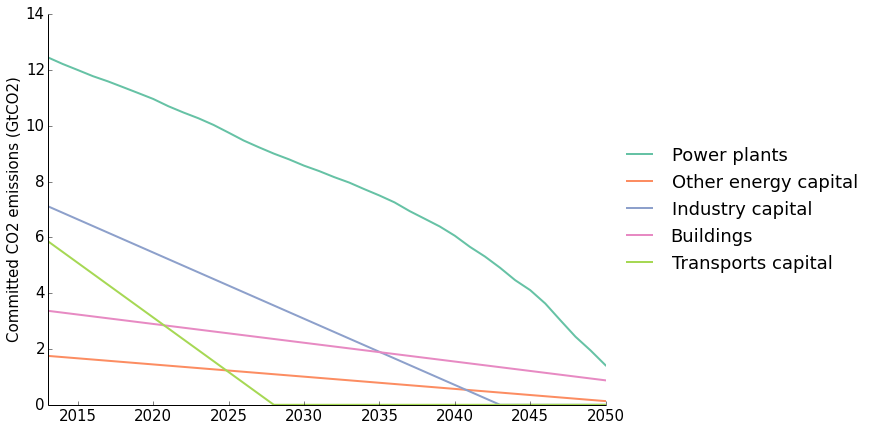

In [41]:
tertlife=50
transplife=15
induslife=30
eleclife=40

elec_comit_scenar=get_elec_comit(eleclife,myyears,elec_comit)
co2_energy_not_power=co2_ener-elec_comit_scenar[0]
enernotpower_com=calc_comit_e(eleclife,co2_energy_not_power,myyears)
industry_com=calc_comit_e(induslife,co2_industry,myyears)
tertiary_com=calc_comit_e(tertlife,co2_tertiary,myyears)
transport_com=calc_comit_e(transplife,co2_transport,myyears)

thecolors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']

font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

plt.plot(myyears,10**(-9)*elec_comit_scenar,color=thecolors[0],linewidth=2,label="Power plants")
plt.plot(myyears,10**(-9)*enernotpower_com,color=thecolors[1],linewidth=2,label="Other energy capital")
plt.plot(myyears,10**(-9)*industry_com,color=thecolors[2],linewidth=2,label="Industry capital")
plt.plot(myyears,10**(-9)*tertiary_com,color=thecolors[3],linewidth=2,label="Buildings")
plt.plot(myyears,10**(-9)*transport_com,color=thecolors[4],linewidth=2,label="Transports capital")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylabel("Committed CO2 emissions (GtCO2)")
ax.set_xlim([2013,2050])

#plt.savefig(figures_path+"committed.eps",format='eps',dpi=1000,bbox_inches="tight")

# first analysis

In [43]:
IC_growth=0
ini_year=2013
budget=915
poprate=0.008
tertlife=50
transplife=15
induslife=50
eleclife=60
GDPgrate=0.03

carb_intens_new_GDP,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,carb_int_ref,gdp_pc_ref,
                                                         poprate,pop_ref,eleclife,myyears,elec_comit,co2_industry,
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,ini_year,co2_ener)
print(carb_intens_new_GDP)
print(sum(total_comit))

26.7921702393
762.100762156


In [45]:
sum(rcp26full(myyears))

249.23540000000006

In [25]:
sum(rcp45full(myyears))

403.43850000000003

This below takes quite some time, so I save the results in "outputs915.csv". To use again just load the csv

In [58]:
out=DataFrame(columns=['eleclife','budget', 'induslife','tertlife','transplife', 'GDPgrate', 'poprate',
                       'carb_intens_new_GDP','remain_e'])

IC_growth=0
ini_year=2013
budget=sum(44/12*rcp26full(myyears))
for eleclife in [60,50,40,30,20]:
    for scenar in scenarios.index:
        [induslife,tertlife,transplife, GDPgrate, poprate]=scenarios.loc[scenar,:].values
        carb_intens_new_GDP,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,carb_int_ref,gdp_pc_ref,
                                                                 poprate,pop_ref,eleclife,myyears,elec_comit,co2_industry,
                                                                 co2_tertiary,co2_transport,induslife,tertlife,transplife,
                                                                 ini_year,co2_ener)
        out.loc[len(out.index)]=[eleclife,budget]+list(scenarios.loc[scenar,:].values)+[carb_intens_new_GDP,remain_e]

out=out.astype(float)
#out.to_csv("test_rcp26.csv")

In [59]:
#out = read_csv("outputs915.csv")

formula="carb_intens_new_GDP ~ tertlife + induslife + transplife + GDPgrate + poprate +eleclife"
olsmodel=ols(formula,data=out).fit()
table=anova_lm(olsmodel)
table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
table=table.sort(['sum_sq'],ascending=False)

In [60]:
table

,df,sum_sq,mean_sq,F,PR(>F),sum_sq_pc
GDPgrate,1,1593845.970315,1593845.970315,33600.511050,0.000000e+00,0.555409
eleclife,1,769446.961597,769446.961597,16221.022368,0.000000e+00,0.268130
induslife,1,249509.368493,249509.368493,5260.007836,0.000000e+00,0.086947
Residual,2493,118255.880040,47.435170,NaN,NaN,0.041209
transplife,1,66641.825764,66641.825764,1404.903262,2.939188e-244,0.023223
poprate,1,50867.335729,50867.335729,1072.354862,6.056770e-196,0.017726
tertlife,1,21114.112267,21114.112267,445.115134,4.774329e-91,0.007358


In [56]:
out45=DataFrame(columns=['eleclife','budget', 'induslife','tertlife','transplife', 'GDPgrate', 'poprate',
                       'carb_intens_new_GDP','remain_e'])

IC_growth=0
ini_year=2013
budget=sum(rcp45full(myyears))
for eleclife in [60,50,40,30,20]:
    for scenar in scenarios.index:
        [induslife,tertlife,transplife, GDPgrate, poprate]=scenarios.loc[scenar,:].values
        carb_intens_new_GDP,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,carb_int_ref,gdp_pc_ref,
                                                                 poprate,pop_ref,eleclife,myyears,elec_comit,co2_industry,
                                                                 co2_tertiary,co2_transport,induslife,tertlife,transplife,
                                                                 ini_year,co2_ener)
        out45.loc[len(out45.index)]=[eleclife,budget]+list(scenarios.loc[scenar,:].values)+[carb_intens_new_GDP,remain_e]

out45=out45.astype(float)
out45.to_csv("outputs_rcp45.csv")

In [57]:
out['committed']=out['budget']-10**(-(9))*out['remain_e']

In [58]:
out["carb_intens_new_GDP"].describe()

count    2500.000000
mean        0.075690
std         0.032306
min         0.015800
25%         0.050604
50%         0.070765
75%         0.096997
max         0.174702
dtype: float64

In [59]:
out45["carb_intens_new_GDP"].describe()

count    2500.000000
mean        0.204189
std         0.072171
min         0.086732
25%         0.144380
50%         0.190027
75%         0.257557
max         0.424945
dtype: float64

In [30]:
np.percentile(out['carb_intens_new_GDP'],[5,95])

array([ 0.03160194,  0.13780334])

Decrease compared to today:

In [31]:
0.38/np.percentile(out['carb_intens_new_GDP'],[5,95])

array([ 12.02457657,   2.75755298])

In [32]:
y_pos = np.arange(len(table))
x = 100*table['sum_sq_pc'].copy()
titles = ['Lifetime of energy capital\n(mostly power plants)', 'GDP growth rate', 'Combination of parameters', 
          'Lifetime of industry capital','Lifetime of transport capital', 'Lifetime of buildings', 'Population growth rate']

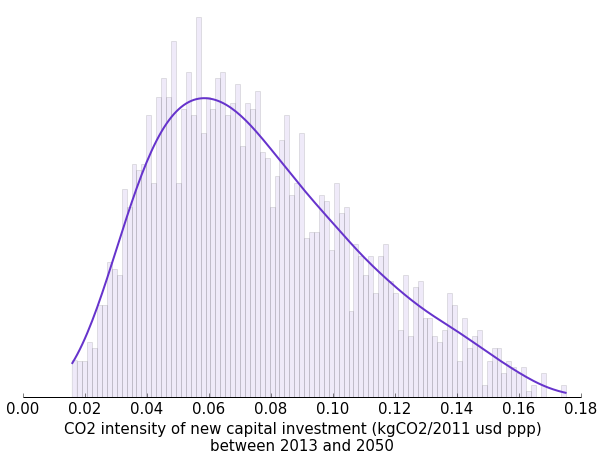

In [33]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

plt.hist(out['carb_intens_new_GDP'],bins=100,alpha=0.1,normed=1,color="#6633CC")
density = gaussian_kde(out['carb_intens_new_GDP'])
xs = np.linspace(out['carb_intens_new_GDP'].min(),out['carb_intens_new_GDP'].max(),200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color="#6633CC")
plt.xlabel('CO2 intensity of new capital investment (kgCO2/2011 usd ppp)\nbetween 2013 and 2050')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
plt.savefig(figures_path+"hist.eps",format='eps',dpi=1000)

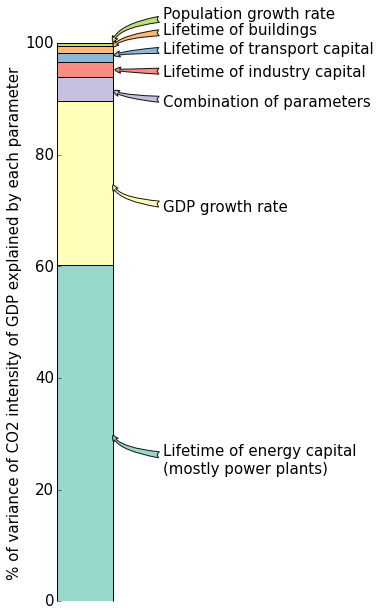

In [34]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(1,10))
ax = plt.subplot(111)

prev = 0
k = 0
colors = ["#8dd3c7","#ffffb3","#bebada","#fb8072","#80b1d3","#fdb462","#b3de69"]

for i,j in enumerate(x):
    plt.plot([0,0],[prev,prev+j],color="black")
    plt.plot([1,1],[prev,prev+j],color=colors[i])
    ax.fill_between([0,1], prev, prev+j,facecolor=colors[i],alpha=0.9)
    (xpos,ypos)=(50, -40+k)
    ang=str(90)
    plt.annotate(titles[i], xy=(1,np.mean([prev,prev+j])),  xycoords='data',
                    xytext=(xpos,ypos), textcoords='offset points',
                    arrowprops=dict(arrowstyle="fancy",
                                    fc=colors[i], ec="black",
                                    patchB=None,alpha=0.9,
                                    connectionstyle="angle3,angleA=0,angleB={}".format(ang)),
                        )
    prev += j
    k+= 11

#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks([])
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.set_ylim([0,100])
plt.ylabel("% of variance of CO2 intensity of GDP explained by each parameter")
plt.savefig(figures_path+"anova_firstanalysis.eps",format='eps',bbox_inches="tight",dpi=1000)

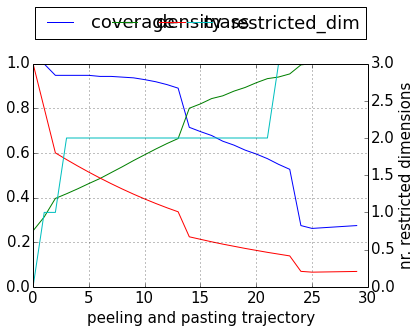

In [28]:
from lib_for_prim import *
experiments=out[['tertlife', 'induslife', 'transplife', 'GDPgrate', 'poprate','eleclife']]
outcomes=out[['carb_intens_new_GDP']]
outcomes['un']=0+outcomes['carb_intens_new_GDP']<0.051
outcomes['deux']=0+outcomes['carb_intens_new_GDP']>0.098
forprim=format_data(outcomes,experiments,"un")
prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
box = prim_obj.find_box()
box.show_ppt()
plt.show()

In [29]:
box.inspect(3)

coverage    0.947368
density     0.416842
mass        0.570000
mean        0.416842
res dim     2.000000
Name: 3, dtype: float64

              box 3                         
                min        max     qp values
eleclife  35.000000  60.000000  5.091486e-36
GDPgrate   0.002024   0.039943  5.470159e-02



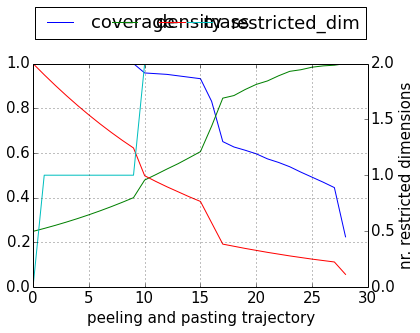

In [30]:
forprim2=format_data(outcomes,experiments,"deux")
prim_obj2   = prim.Prim(forprim2, classify, mass_min = 0.01, threshold=.5)
box2 = prim_obj2.find_box()
box2.show_ppt()
plt.show()

In [31]:
box2.inspect(22)

coverage    0.557166
density     0.945355
mass        0.146400
mean        0.945355
res dim     2.000000
Name: 22, dtype: float64

             box 22                          
                min        max      qp values
GDPgrate   0.000042   0.014648  3.847831e-103
eleclife  20.000000  35.000000   1.665358e-53



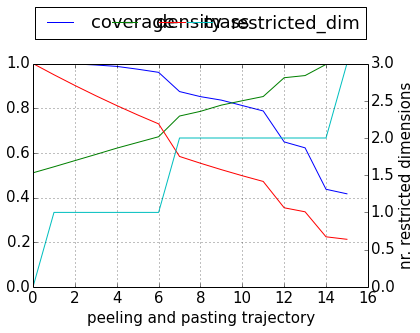

In [32]:
outcomes['trois']=0+outcomes['carb_intens_new_GDP']>0.07
forprim3=format_data(outcomes,experiments,"trois")
prim_obj3   = prim.Prim(forprim3, classify, mass_min = 0.01, threshold=.5)
box3 = prim_obj3.find_box()
box3.show_ppt()
plt.show()

In [33]:
box3.inspect(13)

coverage    0.622553
density     0.946429
mass        0.336000
mean        0.946429
res dim     2.000000
Name: 13, dtype: float64

             box 13                         
                min        max     qp values
GDPgrate   0.000042   0.022385  3.147259e-90
eleclife  20.000000  45.000000  1.439379e-43



# Second analysis

In [60]:
def run_scenarios(outall,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_comit,co2_industry,co2_tertiary,co2_transport,co2_ener,ini_year=2013,budget=900,eleclist=[60,50,40,30,20],IC_growth=0):
    outy=DataFrame(columns=['ini_year','eleclife','budget', 'induslife','tertlife','transplife', 'GDPgrate', 'poprate','carb_intens_new_GDP','remain_e','total_comit'])
    for eleclife in eleclist:
        for scenar in scenarios.index:
            [induslife,tertlife,transplife, GDPgrate, poprate]=scenarios.loc[scenar,:].values
            carb_intens_new_GDP,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,carb_int_ref,gdp_pc_ref,poprate,pop_ref,eleclife,myyears,elec_comit,co2_industry,co2_tertiary,co2_transport,induslife,tertlife,transplife,ini_year,co2_ener)
            outy.loc[len(outy.index)]=[ini_year,eleclife,budget]+list(scenarios.loc[scenar,:].values)+[carb_intens_new_GDP,remain_e,sum(total_comit)]
    outall=outall.append(outy.astype(float),ignore_index=True)
    return outall


def vary_a_parameter(param_list,csvname,param2change,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_comit,co2_industry,co2_tertiary,co2_transport,co2_ener):

    if os.path.isfile(csvname):
        outall=read_csv(csvname)
    else:
        outall=DataFrame(columns=['ini_year','eleclife','budget', 'induslife','tertlife','transplife', 'GDPgrate', 'poprate','carb_intens_new_GDP','remain_e'])
        IC_growth=0
        for theparam in param_list:
            if param2change=='ini_year':
                outall=run_scenarios(outall,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_comit,
                                     co2_industry,co2_tertiary,co2_transport,co2_ener,ini_year=theparam)
            elif param2change=='budget':
                outall=run_scenarios(outall,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_comit,
                                     co2_industry,co2_tertiary,co2_transport,co2_ener,budget=theparam)
        outall.to_csv(csvname,index=False)
    return outall


In [61]:
date_list=[2013,2015,2017,2019,2021]
outall=vary_a_parameter(date_list,"output_all_years_march3.csv","ini_year",scenarios,carb_int_ref,gdp_pc_ref,
                        pop_ref,myyears,elec_comit,co2_industry,co2_tertiary,co2_transport,co2_ener)

In [24]:
outall.ix[outall['ini_year']==2021,:].describe()

,GDPgrate,budget,carb_intens_new_GDP,eleclife,induslife,ini_year,poprate,remain_e,tertlife,total_comit,transplife
count,2500.000000,2500,2500.000000,2500.000000,2500.000000,2500,2500.000000,2.500000e+03,2500.000000,2.500000e+03,2500.000000
mean,0.020000,900,-0.003337,40.000000,29.998732,2021,0.008050,-1.814613e+10,60.002643,6.094393e+11,17.499790
std,0.011550,0,0.044377,14.144965,11.549689,0,0.001934,1.312563e+11,23.099811,1.241534e+11,7.218992
min,0.000042,900,-0.104933,20.000000,10.059770,2021,0.004703,-3.683102e+11,20.141688,2.947752e+11,5.039258
25%,0.010019,900,-0.037865,30.000000,20.033849,2021,0.006374,-1.126439e+11,40.098472,5.178791e+11,11.275912
50%,0.020000,900,-0.006492,40.000000,29.978696,2021,0.008054,-1.756260e+10,60.000197,6.123377e+11,17.481837
75%,0.030004,900,0.026338,50.000000,39.988742,2021,0.009722,7.744219e+10,80.010137,7.003456e+11,23.753846
max,0.039943,900,0.134536,60.000000,49.968019,2021,0.011400,3.220725e+11,99.952288,9.396861e+11,29.959116


C:\Miniconda3\lib\site-packages\matplotlib\font_manager.py:1236: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


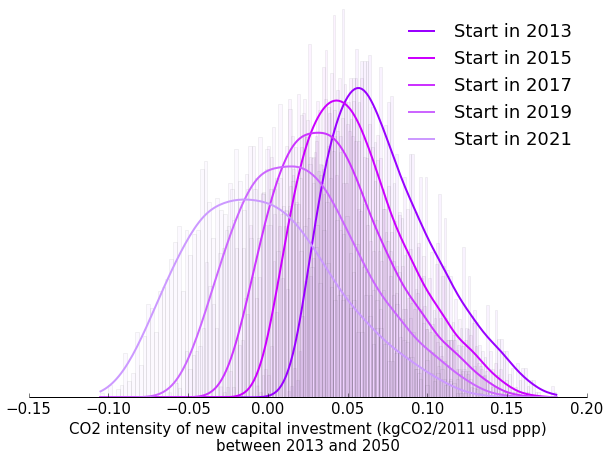

In [25]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

color_list=["#9900FF","#CC00FF","#CC33FF","#CC66FF","#CC99FF","#CCCCFF","#CCFFFF"]

for theparam in date_list:
    thecolor=color_list[date_list.index(theparam)]
    data=outall.ix[outall['ini_year']==theparam,'carb_intens_new_GDP']
    plt.hist(np.array(data),bins=100,alpha=0.05,normed=1,color=thecolor)
    density = gaussian_kde(data)
    xs = np.linspace(outall['carb_intens_new_GDP'].min(),outall['carb_intens_new_GDP'].max(),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    strlabel="Start in {}".format(theparam)
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=strlabel)

plt.legend(loc='upper right',frameon=False)
plt.xlabel('CO2 intensity of new capital investment (kgCO2/2011 usd ppp)\nbetween 2013 and 2050')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
plt.savefig(figures_path+"hist_diff_ini_year.eps",format='eps',dpi=1000)

In [64]:
budget_list=[550,800,1050,1300]
outall2=vary_a_parameter(budget_list,"output_all_budgets_march3.csv","budget",scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_comit,co2_industry,co2_tertiary,co2_transport,co2_ener)

In [63]:
for budget in budget_list:
    experiments=outall2.ix[outall2['budget']==budget,['tertlife', 'induslife', 'transplife', 'GDPgrate', 'poprate','eleclife']]
    outcomes=outall2.ix[outall2['budget']==budget,['carb_intens_new_GDP']]
    experiments.to_csv("experiments{}.csv".format(budget),index=False)
    outcomes.to_csv("outcomes{}.csv".format(budget),index=False)


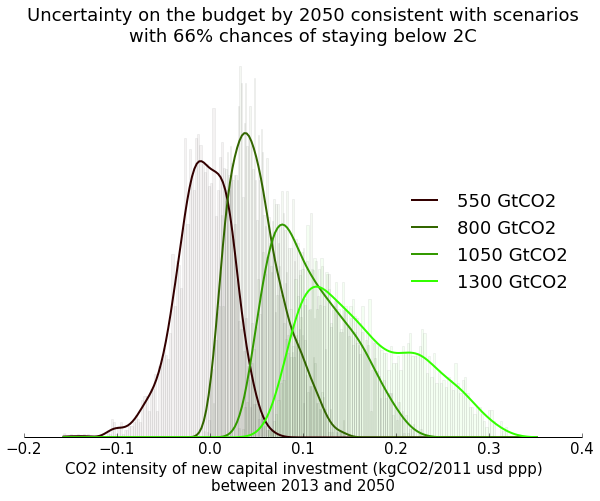

In [28]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

budget_list=[550,800,1050,1300]

color_list=["#330000","#336600","#339900","#33FF00"]

for theparam in budget_list:
    thecolor=color_list[budget_list.index(theparam)]
    data=outall2.ix[outall2['budget']==theparam,'carb_intens_new_GDP']
    plt.hist(np.array(data),bins=100,alpha=0.05,normed=1,color=thecolor)
    density = gaussian_kde(data)
    xs = np.linspace(outall2['carb_intens_new_GDP'].min(),1.1*outall2['carb_intens_new_GDP'].max(),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    strlabel="{} GtCO2".format(theparam)
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=strlabel)

plt.legend(loc='center right',frameon=False)
plt.xlabel('CO2 intensity of new capital investment (kgCO2/2011 usd ppp)\nbetween 2013 and 2050')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
plt.title("Uncertainty on the budget by 2050 consistent with scenarios\nwith 66% chances of staying below 2C")
plt.savefig(figures_path+"hist_diff_budget.eps",format='eps',dpi=1000)

In [29]:
from lib_for_prim import *

In [30]:
for budget in [550]:
    experiments=outall2.ix[outall2['budget']==budget,['tertlife', 'induslife', 'transplife', 'GDPgrate', 'poprate','eleclife']]
    outcomes=outall2.ix[outall2['budget']==budget,['carb_intens_new_GDP']]
    outcomes['pos']=0+outcomes['carb_intens_new_GDP']>0
    forprim=format_data(outcomes,experiments,"pos")
    prim_obj   = prim.Prim(forprim, classify, mass_min = 0.01, threshold=.5)
    box = prim_obj.find_box()


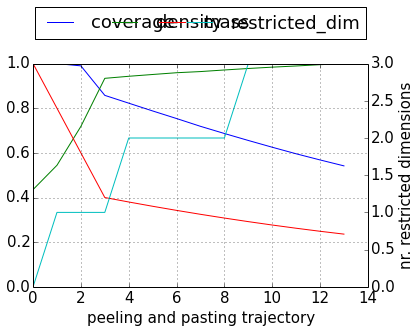

In [179]:
box.show_ppt()
plt.show()

In [181]:
box.inspect(4)

coverage    0.822773
density     0.943158
mass        0.380000
mean        0.943158
res dim     2.000000
Name: 4, dtype: float64

               box 4                          
                 min        max      qp values
eleclife   20.000000  35.000000  7.010195e-243
induslife  10.004699  47.986546   1.411674e-01



In [49]:
sum(outcomes['pos'])/len(outcomes)

0.1764

In [32]:
budget_list=[0,550,1300,1740]
outall3=vary_a_parameter(budget_list,"output_all_budgets_climate.csv","budget",scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_comit,co2_industry,co2_tertiary,co2_transport,co2_ener)

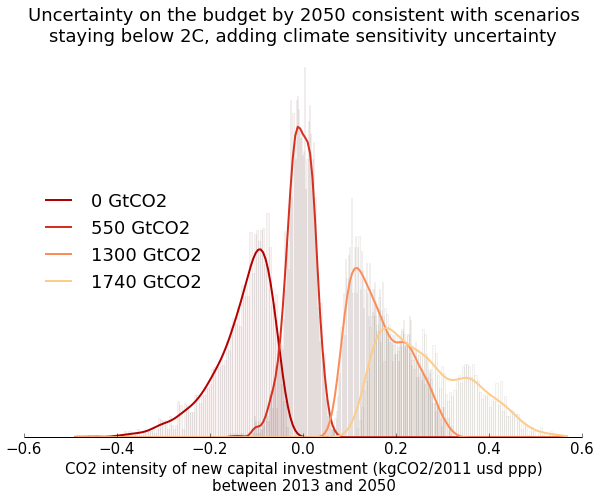

In [33]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

budget_list=[0,550,1300,1740]
color_list=['#b30000',"#d7301f","#fc8d59","#fdcc8a"]

for theparam in budget_list:
    thecolor=color_list[budget_list.index(theparam)]
    data=outall3.ix[outall3['budget']==theparam,'carb_intens_new_GDP']
    plt.hist(np.array(data),bins=100,alpha=0.05,normed=1,color=thecolor)
    density = gaussian_kde(data)
    xs = np.linspace(outall3['carb_intens_new_GDP'].min(),outall3['carb_intens_new_GDP'].max(),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    strlabel="{} GtCO2".format(theparam)
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=strlabel)

plt.legend(loc='center left',frameon=False)
plt.xlabel('CO2 intensity of new capital investment (kgCO2/2011 usd ppp)\nbetween 2013 and 2050')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
plt.title("Uncertainty on the budget by 2050 consistent with scenarios\nstaying below 2C, adding climate sensitivity uncertainty")
plt.savefig(figures_path+"hist_diff_budget_climate.eps",format='eps',dpi=1000)